# Variational Bayesian Inference on Mixture of Gaussians

A tutorial bases on section 10.1.13 in Bishop 2006 machine learning book and the code in `https://github.com/jamesmcinerney/vbmm`

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.special.basic import digamma

In [18]:
custom_N         = 200
custom_K         = 2 
custom_probs     = [0.2, 0.8]
custom_mu        = [[0,0], [10,10]] 
custom_sigma2    = [[[2, 1],[1,2]], [[2, 1],[1,2]]]
custom_save_path = "/Users/mohsenk/Dropbox/research2019/MoG-MFVB/jupyter-notebooks/"

In [3]:
def create_cov_ellipse(cov, pos, nstd=2, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    return ellip

In [20]:
def generate_MoG_samples(N, probs, mu_vec, sigma2_vec):
    """
    Custom function to generate N samples from a Mixture of Gaussians distribution. 
    
    Args:

        N (int): Total number of created samples. 
        probs (list): A list of probability elements which should be non-negative and which should 
                      should add up to one.
        mu_vec (list[list]): The list of all coordinates for means of the K Gaussian distributions.
                             each element of this list is a D-dimensional list where D is the 
                             dimensionality of the individual Gaussian distributions (2 in our examples).
        sigma2_vec (list[list[list]]): The list of covariance matrices for all K Gaussian distributions. 
        
    Returns
        A Numpy array of shape (N, D) where D = len(mu_vec[0]) is the dimensionality of the problem. 

    """
    selected_gaussian_index = np.random.choice(list(range(1,len(probs)+1)), N, p=probs)
    data = np.random.multivariate_normal(mu_vec[0], sigma2_vec[0])
    for i in range(1,N):
        idx = selected_gaussian_index[i]-1
        mean, cov = mu_vec[idx], sigma2_vec[idx]
        sample_point  = np.random.multivariate_normal(mean, cov)
        data = np.vstack((data, sample_point))
        #x = data[:,0]
        #y = data[:,1]
    return data

In [5]:
def gen(K,N,XDim):
    #K: number of components
    #N: number of data points
    
    mu = np.array([np.random.multivariate_normal(np.zeros(XDim),10*np.eye(XDim)) for _ in range(K)])
    cov = [0.1*np.eye(XDim) for _ in range(K)]
    q = np.random.dirichlet(np.ones(K)) #component coefficients
    X = np.zeros((N,XDim)) #observations
    Z = np.zeros((N,K)) #latent variables
    for n in range(N):
        #decide which component has responsibility for this data point:
        Z[n,:] = np.random.multinomial(1, q)
        k = Z[n,:].argmax()
        X[n,:] =  np.random.multivariate_normal(mu[k,:],cov[k])
    return X

In [6]:
def run(X,K,save_dir_name,VERBOSE=True):
    #X: observations
    (N,XDim) = np.shape(X)
    
    #hyperparams:
    alpha0 = 0.1 #prior coefficient count (for Dir)
    beta0 = (1e-20)*1. #variance of mean (smaller: broader the means)
    v0 = XDim+1. #2. #degrees of freedom in inverse wishart
    m0 = np.zeros(XDim) #prior mean
    W0 = (1e0)*np.eye(XDim) #prior cov (bigger: smaller covariance)
    
    #params:
    #Z = ones((N,K))/float(K) #uniform initial assignment
    Z = np.array([np.random.dirichlet(np.ones(K)) for _ in range(N)])

    #ion()    
    fig = plt.figure(figsize=(10,10))
    ax_spatial = fig.add_subplot(1,1,1) #http://stackoverflow.com/questions/3584805/in-matplotlib-what-does-111-means-in-fig-add-subplot111
    circs = []
                
    
    itr, max_itr = 0, 200
    while itr < max_itr:
        #M-like-step
        NK = Z.sum(axis=0)
        vk = v0 + NK + 1.
        xd = calcXd(Z,X)
        S = calcS(Z,X,xd,NK)
        betak = beta0 + NK
        m = calcM(K,XDim,beta0,m0,NK,xd,betak)
        W = calcW(K,W0,xd,NK,m0,XDim,beta0,S)

        #E-like-step
        mu = Muopt(X,XDim,NK,betak,m,W,xd,vk,N,K) #eqn 10.64 Bishop
        invc = Invcopt(W,vk,XDim,K) #eqn 10.65 Bishop
        pik = Piopt(alpha0,NK) #eqn 10.66 Bishop
        Z = Zopt(XDim, pik, invc, mu, N, K) #eqn 10.46 Bishop
        
        if VERBOSE:
            print('itr %i'%itr)
            #print('means',m)
            #print('Z',Z)
            #print('mu',mu)
            #print('invc',invc)
            #print('exp(pik)',np.exp(pik))
            #print('NK',NK)
            if itr==0:
                sctX = plt.scatter(X[:,0],X[:,1])
                sctZ = plt.scatter(m[:,0],m[:,1],color='r')
            else:
                #ellipses to show covariance of components
                for circ in circs: circ.remove()
                circs = []
                for k in range(K):
                    circ = create_cov_ellipse(S[k], m[k,:],color='r',alpha=0.3) #calculate params of ellipses (adapted from http://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals)
                    circs.append(circ)
                    #add to axes:
                    ax_spatial.add_artist(circ)
                    #make sure components with NK=0 are not visible:
                    if NK[k]<=alpha0: m[k,:] = m[NK.argmax(),:] #put over point that obviously does have assignments
                sctZ.set_offsets(m)
            plt.draw()
            #time.sleep(0.1)
            plt.savefig(custom_save_path + '{}/%04d.png'.format(save_dir_name)%itr)
        itr += 1
    
    if VERBOSE:
        #keep display:    
        time.sleep(30)
    
    return m,invc,pik,Z

In [7]:
def calcXd(Z,X):
    #weighted means (by component responsibilites)
    (N,XDim) = np.shape(X)
    (N1,K) = np.shape(Z)
    NK = Z.sum(axis=0)
    assert N==N1
    xd = np.zeros((K,XDim))
    for n in range(N):
        for k in range(K):
            xd[k,:] += Z[n,k]*X[n,:]
    #safe divide:
    for k in range(K):
        if NK[k]>0: xd[k,:] = xd[k,:]/NK[k]
    
    return xd

In [8]:
def calcS(Z,X,xd,NK):
    (N,K)=np.shape(Z)
    (N1,XDim)=np.shape(X)
    assert N==N1
    
    S = [np.zeros((XDim,XDim)) for _ in range(K)]
    for n in range(N):
        for k in range(K):
            B0 = np.reshape(X[n,:]-xd[k,:], (XDim,1))
            L = np.dot(B0,B0.T)
            assert np.shape(L)==np.shape(S[k]),np.shape(L)
            S[k] += Z[n,k]*L
    #safe divide:
    for k in range(K):
        if NK[k]>0: S[k] = S[k]/NK[k]
    return S

In [9]:
def calcW(K,W0,xd,NK,m0,XDim,beta0,S):
    Winv = [None for _ in range(K)]
    for k in range(K): 
        Winv[k]  = np.linalg.linalg.inv(W0) + NK[k]*S[k]
        Q0 = np.reshape(xd[k,:] - m0, (XDim,1))
        q = np.dot(Q0,Q0.T)
        Winv[k] += (beta0*NK[k] / (beta0 + NK[k]) ) * q
        assert np.shape(q)==(XDim,XDim)
    W = []
    for k in range(K):
        try:
            W.append(np.linalg.linalg.inv(Winv[k]))
        except np.linalg.linalg.LinAlgError:
            #print('Winv[%i]'%k, Winv[k])
            raise np.linalg.linalg.LinAlgError()
    return W

In [10]:
def calcM(K,XDim,beta0,m0,NK,xd,betak):
    m = np.zeros((K,XDim))
    for k in range(K): m[k,:] = (beta0*m0 + NK[k]*xd[k,:]) / betak[k]
    return m    

In [11]:
def Muopt(X,XDim,NK,betak,m,W,xd,vk,N,K):
    Mu = np.zeros((N,K))
    for n in range(N):
        for k in range(K):
            A = XDim / betak[k] #shape: (k,)
            B0 = np.reshape((X[n,:] - m[k,:]),(XDim,1))
            B1 = np.dot(W[k], B0)
            l = np.dot(B0.T, B1)
            assert np.shape(l)==(1,1),np.shape(l)
            Mu[n,k] = A + vk[k]*l #shape: (n,k)
    
    return Mu

In [12]:
def Piopt(alpha0,NK):
    alphak = alpha0 + NK
    pik = digamma(alphak) - digamma(alphak.sum())
    return pik

In [13]:
def Invcopt(W,vk,XDim,K):
    invc = [None for _ in range(K)]
    for k in range(K):
        dW = np.linalg.linalg.det(W[k])
        #print('dW',dW)
        if dW>1e-30: ld = np.log(dW)
        else: ld = 0.0
        invc[k] = sum([digamma((vk[k]+1-i) / 2.) for i in range(XDim)]) + XDim*np.log(2) + ld
    return invc

In [14]:
def Zopt(XDim, exp_ln_pi, exp_ln_gam, exp_ln_mu, N, K):
    Z = np.zeros((N,K)) #ln Z
    for k in range(K):
        Z[:,k] = exp_ln_pi[k] + 0.5*exp_ln_gam[k] - 0.5*XDim*np.log(2*np.pi) - 0.5*exp_ln_mu[:,k]
    #normalise ln Z:
    Z -= np.reshape(Z.max(axis=1),(N,1))
    Z1 = np.exp(Z) / np.reshape(np.exp(Z).sum(axis=1), (N,1))
    return Z1

itr 0
itr 1
itr 2
itr 3
itr 4
itr 5
itr 6
itr 7
itr 8
itr 9
itr 10
itr 11
itr 12
itr 13
itr 14
itr 15
itr 16
itr 17
itr 18
itr 19
itr 20
itr 21
itr 22
itr 23
itr 24
itr 25
itr 26
itr 27
itr 28
itr 29
itr 30
itr 31
itr 32
itr 33
itr 34
itr 35
itr 36
itr 37
itr 38
itr 39
itr 40
itr 41
itr 42
itr 43
itr 44
itr 45
itr 46
itr 47
itr 48
itr 49
itr 50
itr 51
itr 52
itr 53
itr 54
itr 55
itr 56
itr 57
itr 58
itr 59
itr 60
itr 61
itr 62
itr 63
itr 64
itr 65
itr 66
itr 67
itr 68
itr 69
itr 70
itr 71
itr 72
itr 73
itr 74
itr 75
itr 76
itr 77
itr 78
itr 79
itr 80
itr 81
itr 82
itr 83
itr 84
itr 85
itr 86
itr 87
itr 88
itr 89
itr 90
itr 91
itr 92
itr 93
itr 94
itr 95
itr 96
itr 97
itr 98
itr 99
itr 100
itr 101
itr 102
itr 103
itr 104
itr 105
itr 106
itr 107
itr 108
itr 109
itr 110
itr 111
itr 112
itr 113
itr 114
itr 115
itr 116
itr 117
itr 118
itr 119
itr 120
itr 121
itr 122
itr 123
itr 124
itr 125
itr 126
itr 127
itr 128
itr 129
itr 130
itr 131
itr 132
itr 133
itr 134
itr 135
itr 136
itr 137
itr 13

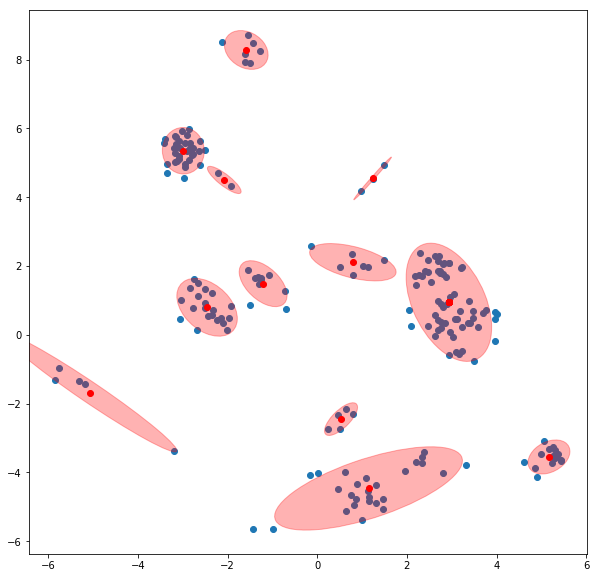

In [15]:
X = gen(30,200,2)
K1 = 20 
mu,invc,pik,Z = run(X,K1,"animation")

In [21]:
Y = generate_MoG_samples(custom_N, custom_probs, custom_mu, custom_sigma2)
print(Y.shape)

(200, 2)


itr 0
itr 1
itr 2
itr 3
itr 4
itr 5
itr 6
itr 7
itr 8
itr 9
itr 10
itr 11
itr 12
itr 13
itr 14
itr 15
itr 16
itr 17
itr 18
itr 19
itr 20
itr 21
itr 22
itr 23
itr 24
itr 25
itr 26
itr 27
itr 28
itr 29
itr 30
itr 31
itr 32
itr 33
itr 34
itr 35
itr 36
itr 37
itr 38
itr 39
itr 40
itr 41
itr 42
itr 43
itr 44
itr 45
itr 46
itr 47
itr 48
itr 49
itr 50
itr 51
itr 52
itr 53
itr 54
itr 55
itr 56
itr 57
itr 58
itr 59
itr 60
itr 61
itr 62
itr 63
itr 64
itr 65
itr 66
itr 67
itr 68
itr 69
itr 70
itr 71
itr 72
itr 73
itr 74
itr 75
itr 76
itr 77
itr 78
itr 79
itr 80
itr 81
itr 82
itr 83
itr 84
itr 85
itr 86
itr 87
itr 88
itr 89
itr 90
itr 91
itr 92
itr 93
itr 94
itr 95
itr 96
itr 97
itr 98
itr 99
itr 100
itr 101
itr 102
itr 103
itr 104
itr 105
itr 106
itr 107
itr 108
itr 109
itr 110
itr 111
itr 112
itr 113
itr 114
itr 115
itr 116
itr 117
itr 118
itr 119
itr 120
itr 121
itr 122
itr 123
itr 124
itr 125
itr 126
itr 127
itr 128
itr 129
itr 130
itr 131
itr 132
itr 133
itr 134
itr 135
itr 136
itr 137
itr 13

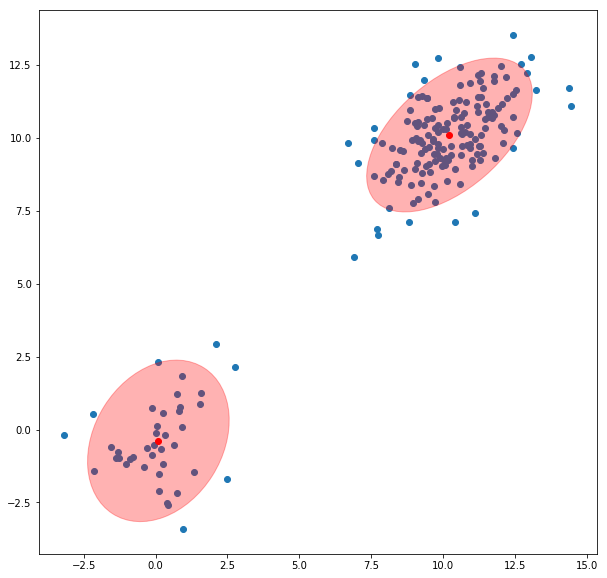

In [22]:
mu,invc,pik,Z = run(Y,2, "my_mog")